In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
mnist_tanh = transforms.Compose([
             transforms.ToTensor(),
             transforms.Normalize((0.5,), (0.5,)),
           ])

In [3]:
with torch.cuda.device(0):
    lr = 4e-4
    z_dim = 2
    batch_size = 50
    train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_tanh)
    fixed_z = torch.randn((batch_size, 2))
    fixed_data, _ = next(iter(test_loader))
    
    batch_zeros = torch.zeros((batch_size, 1))
    batch_ones = torch.ones((batch_size, 1))

# Задание 2. Сделать Adversarial Autoencoder — автокодировщик с лоссом от Дискриминатора вместо KL-дивергенции.

In [4]:
# encoder

class Encoder(nn.Module):
    
    def __init__(self):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(28 * 28, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, z_dim)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        
        return x

In [5]:
# decoder

class Decoder(nn.Module):
    
    def __init__(self):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(z_dim, 256)
        self.linear2 = nn.Linear(256, 512)
        self.linear3 = nn.Linear(512, 28 * 28)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.tanh(self.linear3(x))
        
        return x

In [6]:
# discriminator

class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        self.linear1 = nn.Linear(z_dim, 256)
        self.linear2 = nn.Linear(256, 512)
        self.linear3 = nn.Linear(512, 1)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.sigmoid(self.linear3(x))
        
        return x

In [7]:
# constructing the model

with torch.cuda.device(0):
    enc, dec, disc = Encoder(), Decoder(), Discriminator()      
    
    enc_opt = optim.Adam(enc.parameters(), lr=lr)
    dec_opt = optim.Adam(dec.parameters(), lr=lr)
    disc_opt = optim.Adam(disc.parameters(), lr=lr)

In [8]:
def train(epoch, enc, dec, disc):
    with torch.cuda.device(0):
        train_size = len(train_loader.sampler)
        for batch_idx, (data, _) in enumerate(train_loader):
            enc.zero_grad()
            dec.zero_grad()
            disc.zero_grad()
            
            data = data.view(-1, 28 * 28)
            
            encoded = enc(data)
            decoded = dec(encoded)
            
            # autoencoder reconstruction loss
            loss = F.mse_loss(decoded, data)
            loss.backward()
            enc_opt.step()
            dec_opt.step()
            
            ###############
            
            enc.zero_grad()
            dec.zero_grad()
            disc.zero_grad()
            
            enc.eval()
            
            true_pred = disc(torch.randn(batch_size, z_dim))
            fake_pred = disc(enc(data))
            
            # discriminator loss
            fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
            true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
            disc_loss = 0.5 * (fake_loss + true_loss)
            #disc_loss = -torch.mean(torch.log(true_pred) + torch.log(1 - fake_pred))
            disc_loss.backward()
            disc_opt.step()

            if batch_idx % 500 == 0:
                print('Epoch {}, losses:\nReconstruction loss: {}\nDiscriminator loss: {}\n'.format(epoch, loss, disc_loss))

In [9]:
def test(enc, dec, disc, loader):
    with torch.cuda.device(0):
        test_size = len(loader)
        with torch.no_grad():
            for data, _ in loader:
                data = data.view(-1, 28 * 28)
                
                encoded = enc(data)
                decoded = dec(encoded)
        
                loss = F.mse_loss(decoded, data)
                
                true_pred = disc(torch.randn(batch_size, z_dim))
                fake_pred = disc(enc(data))

                fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
                true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
                disc_loss = 0.5 * (fake_loss + true_loss)
                #disc_loss = -torch.mean(torch.log(true_pred) + torch.log(1 - fake_pred))
                
        loss /= test_size
        disc_loss /= test_size
        
        with torch.no_grad():
            ae_data = dec(enc(fixed_data.view(-1, 28 * 28))).data.numpy()
            fixed_gen = dec(fixed_z).data.numpy()
            plot_mnist(fixed_data, (5, 10), 'Dataset numbers')
            plot_mnist(ae_data.reshape(-1, 1, 28, 28), (5, 10), 'Reconstructed numbers')
            plot_mnist(fixed_gen.reshape(-1, 1, 28, 28), (5, 10), 'Numbers sampled from the Gaussian distribution')
                
        print('Test losses:\nReconstruction loss: {}\nDiscriminator loss: {}\n'.format(loss, disc_loss))

Epoch 1, losses:
Reconstruction loss: 0.936016321182251
Discriminator loss: 0.7222411036491394

Epoch 1, losses:
Reconstruction loss: 0.19727082550525665
Discriminator loss: 0.5874399542808533



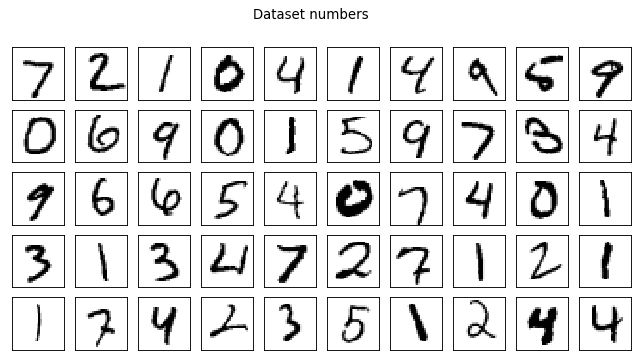

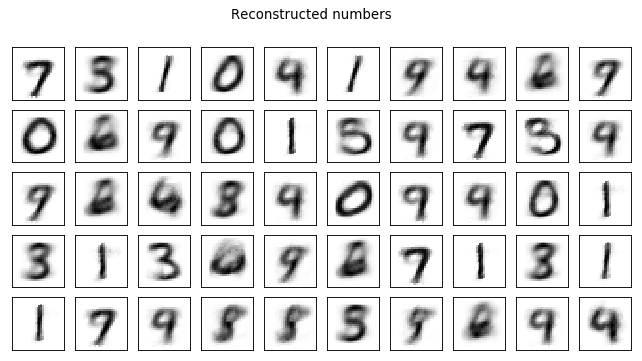

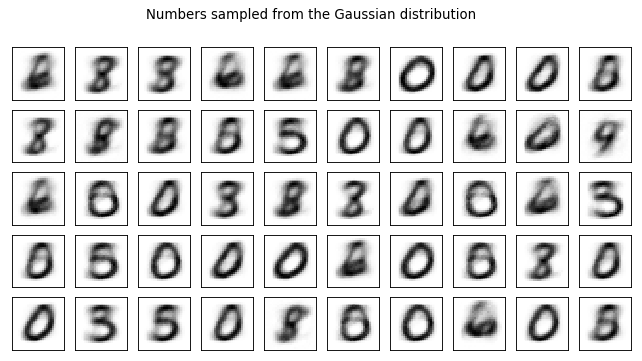

Test losses:
Reconstruction loss: 0.0009444736642763019
Discriminator loss: 0.003259343095123768

Epoch 2, losses:
Reconstruction loss: 0.17897680401802063
Discriminator loss: 0.6099388599395752

Epoch 2, losses:
Reconstruction loss: 0.1764044165611267
Discriminator loss: 0.6385014653205872



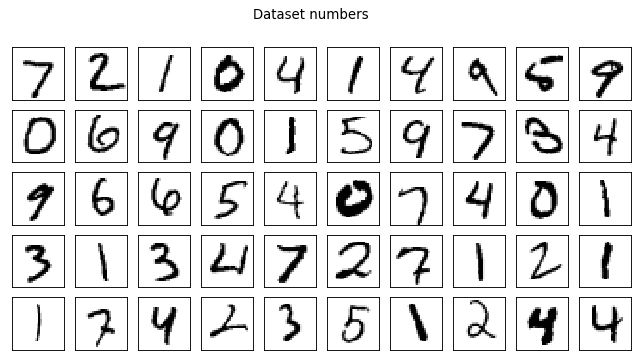

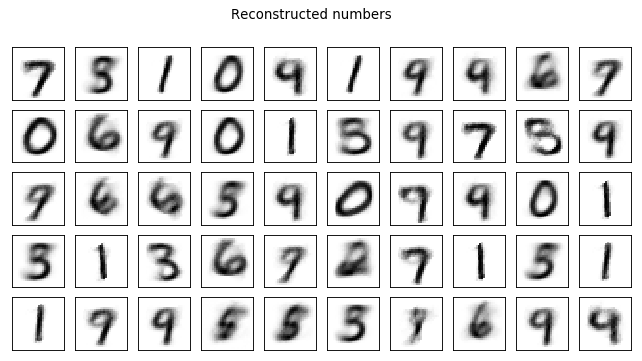

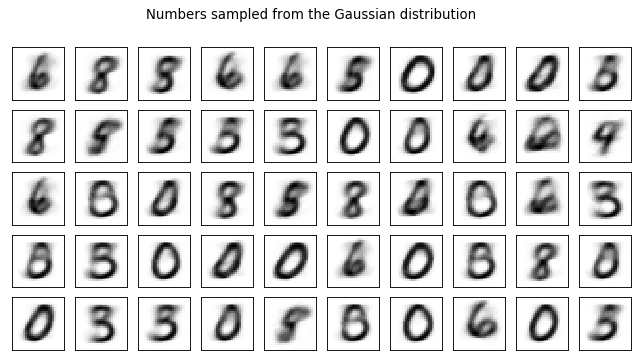

Test losses:
Reconstruction loss: 0.0007525521796196699
Discriminator loss: 0.003057541325688362

Epoch 3, losses:
Reconstruction loss: 0.17205335199832916
Discriminator loss: 0.6156390905380249

Epoch 3, losses:
Reconstruction loss: 0.17516987025737762
Discriminator loss: 0.6441586017608643



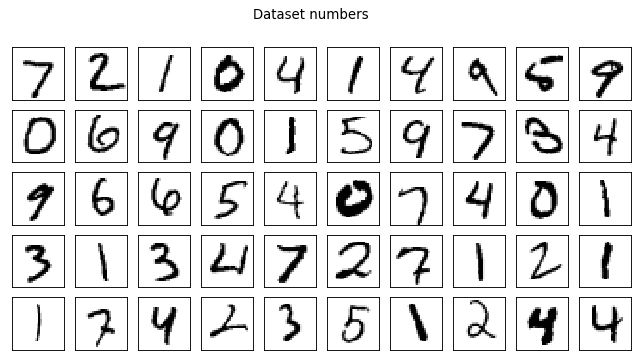

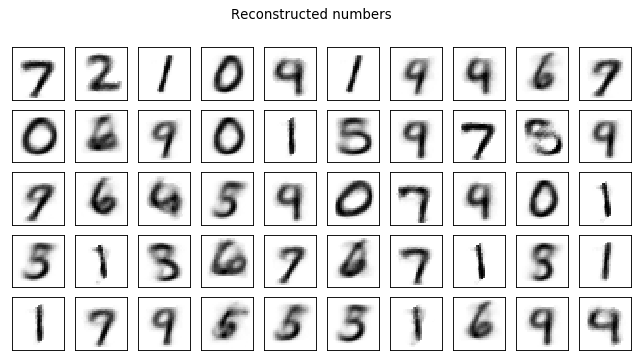

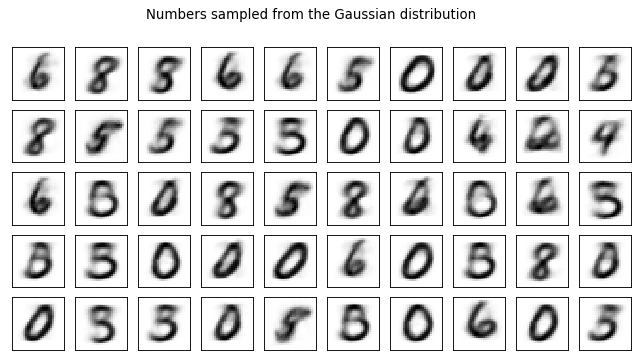

Test losses:
Reconstruction loss: 0.0007260484271682799
Discriminator loss: 0.0031074925791472197

Epoch 4, losses:
Reconstruction loss: 0.16336676478385925
Discriminator loss: 0.6377676725387573

Epoch 4, losses:
Reconstruction loss: 0.14516353607177734
Discriminator loss: 0.6170271039009094



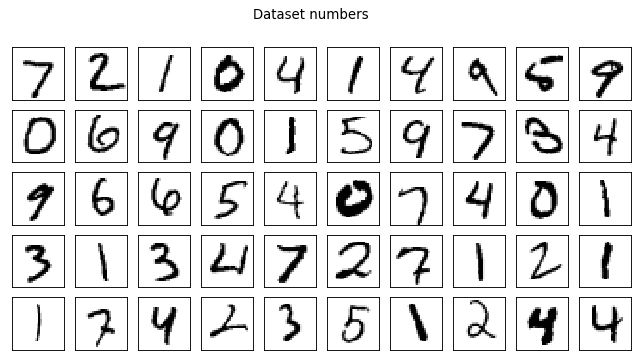

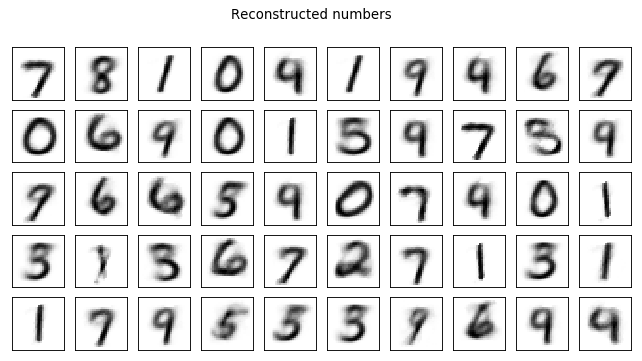

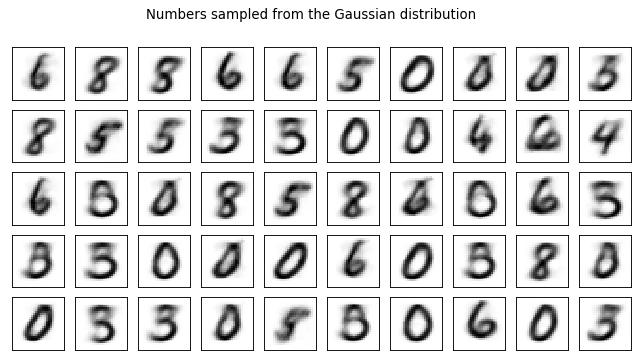

Test losses:
Reconstruction loss: 0.0007943444070406258
Discriminator loss: 0.003087476594373584

Epoch 5, losses:
Reconstruction loss: 0.1582106649875641
Discriminator loss: 0.62579745054245

Epoch 5, losses:
Reconstruction loss: 0.15466918051242828
Discriminator loss: 0.613732099533081



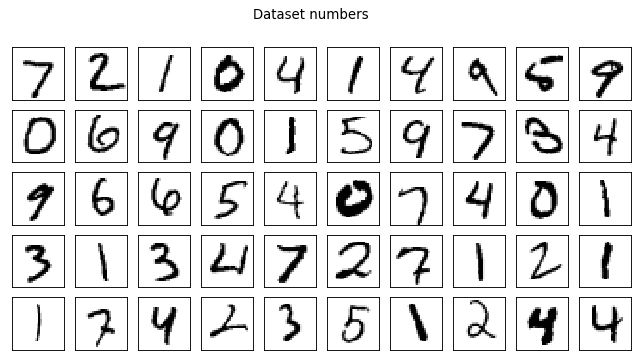

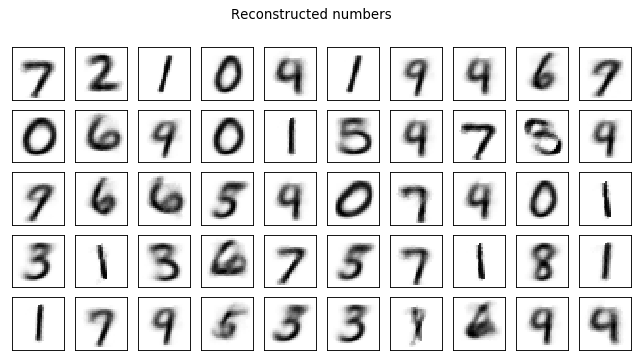

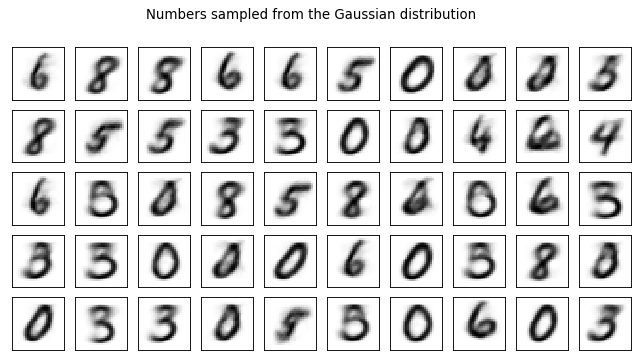

Test losses:
Reconstruction loss: 0.0008697647717781365
Discriminator loss: 0.003017709357663989

Epoch 6, losses:
Reconstruction loss: 0.14934317767620087
Discriminator loss: 0.6156530976295471

Epoch 6, losses:
Reconstruction loss: 0.14636918902397156
Discriminator loss: 0.6199325919151306



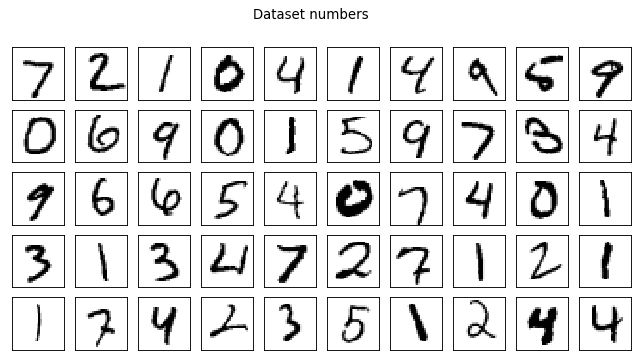

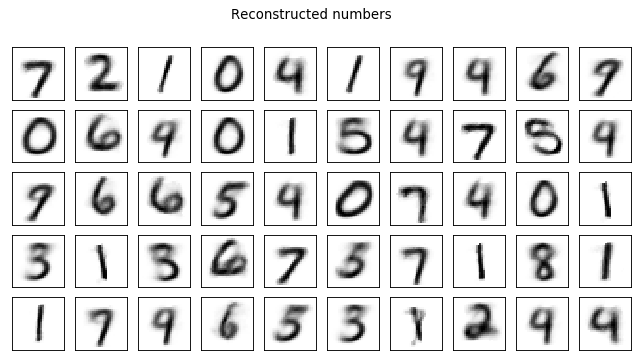

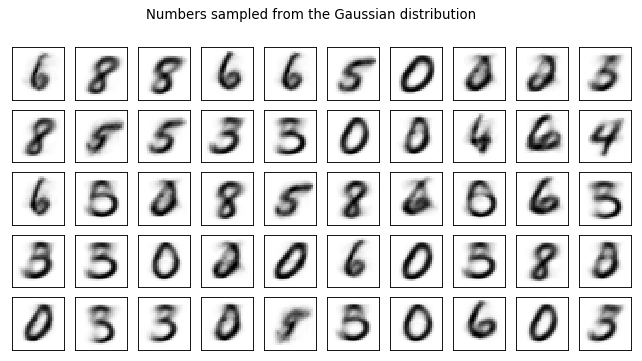

Test losses:
Reconstruction loss: 0.0007501982618123293
Discriminator loss: 0.0031942545901983976

Epoch 7, losses:
Reconstruction loss: 0.15635062754154205
Discriminator loss: 0.6468266248703003

Epoch 7, losses:
Reconstruction loss: 0.14980672299861908
Discriminator loss: 0.5966894626617432



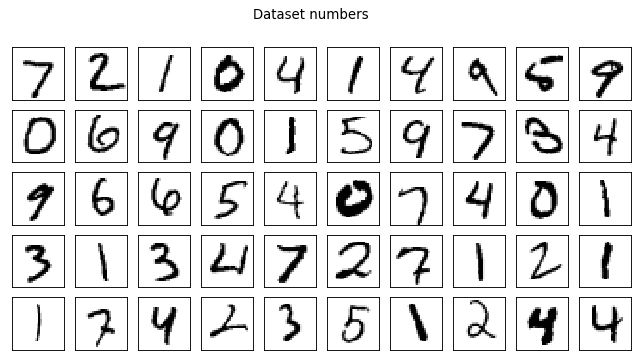

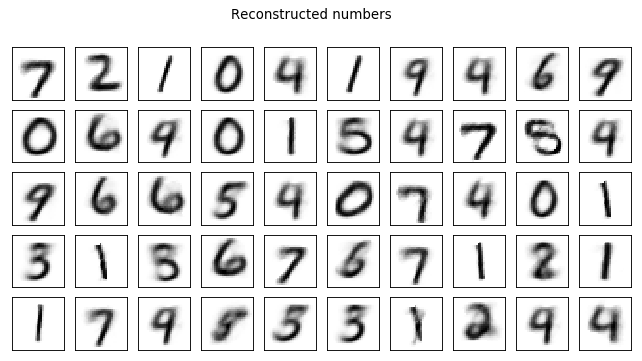

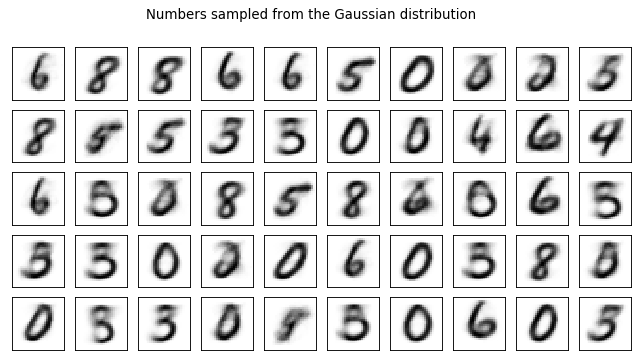

Test losses:
Reconstruction loss: 0.0007951169391162694
Discriminator loss: 0.0032699136063456535

Epoch 8, losses:
Reconstruction loss: 0.14506767690181732
Discriminator loss: 0.6267491579055786

Epoch 8, losses:
Reconstruction loss: 0.16449755430221558
Discriminator loss: 0.633574366569519



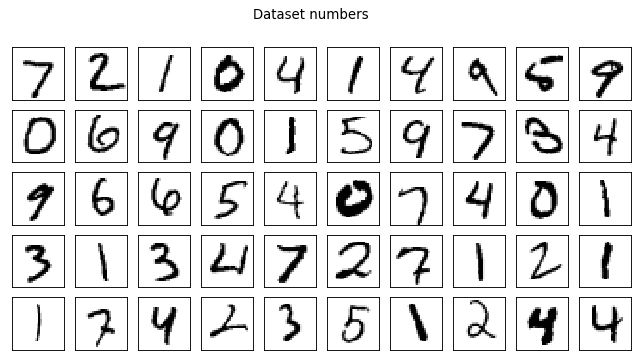

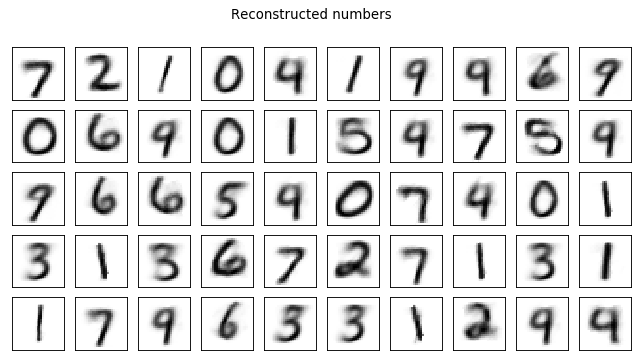

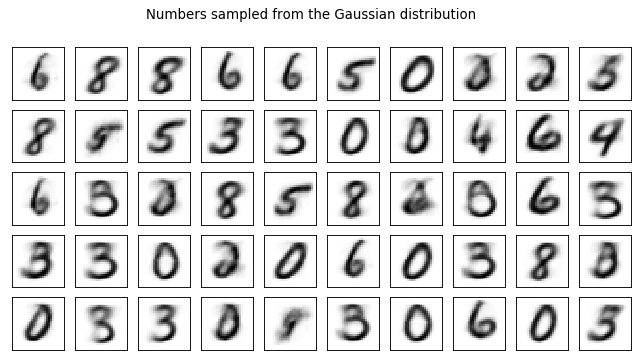

Test losses:
Reconstruction loss: 0.000703356578014791
Discriminator loss: 0.0031729259062558413

Epoch 9, losses:
Reconstruction loss: 0.14798131585121155
Discriminator loss: 0.6101542115211487

Epoch 9, losses:
Reconstruction loss: 0.14695288240909576
Discriminator loss: 0.6230865120887756



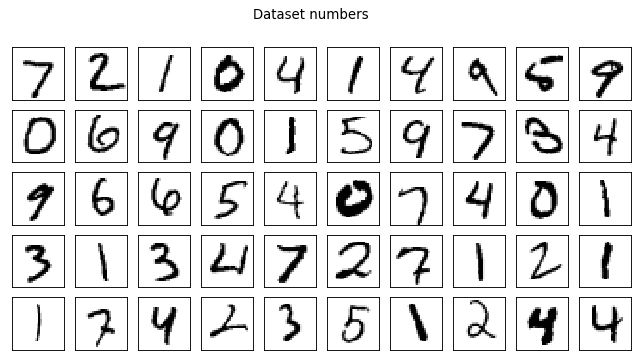

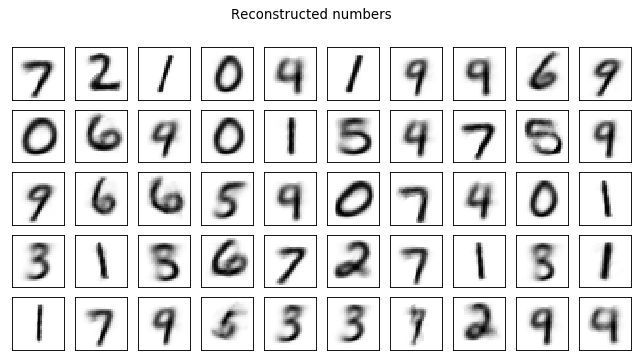

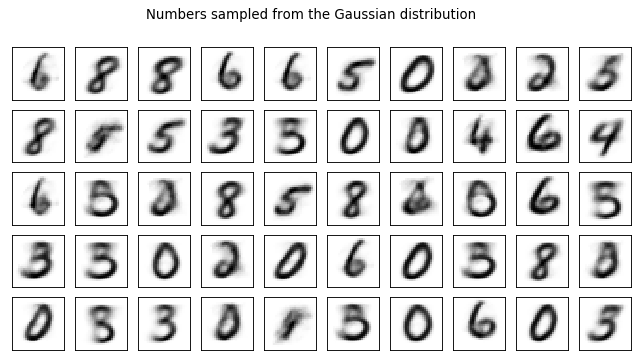

Test losses:
Reconstruction loss: 0.0007457800675183535
Discriminator loss: 0.0029274935368448496

Epoch 10, losses:
Reconstruction loss: 0.15024369955062866
Discriminator loss: 0.6147305965423584

Epoch 10, losses:
Reconstruction loss: 0.13277967274188995
Discriminator loss: 0.6097033023834229



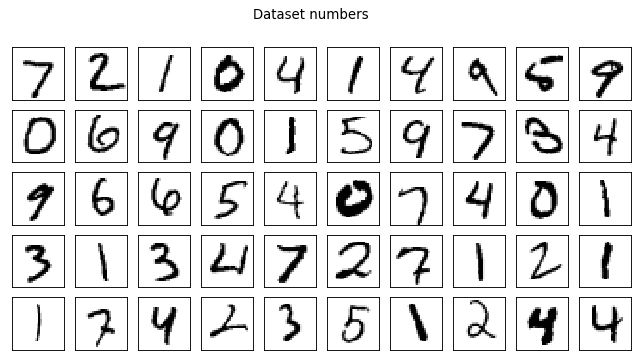

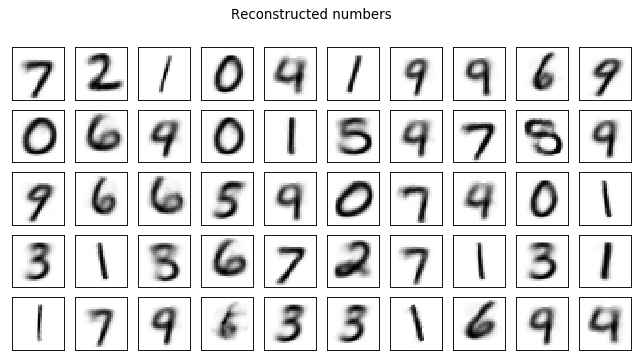

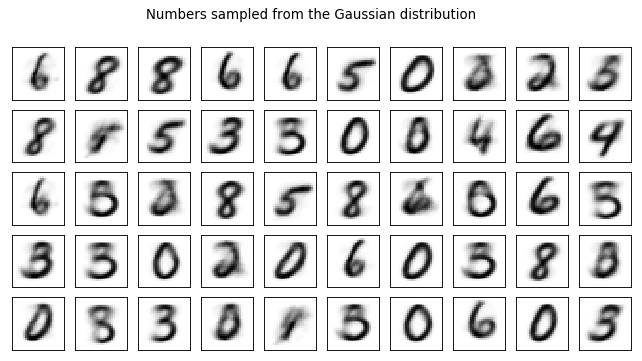

Test losses:
Reconstruction loss: 0.0007483784575015306
Discriminator loss: 0.003136884653940797

Epoch 11, losses:
Reconstruction loss: 0.14895987510681152
Discriminator loss: 0.6376454830169678

Epoch 11, losses:
Reconstruction loss: 0.14752040803432465
Discriminator loss: 0.6167922019958496



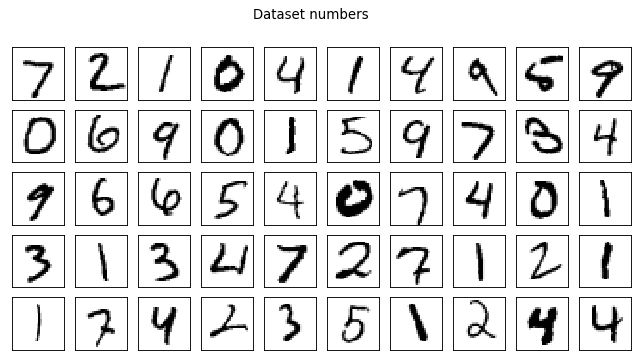

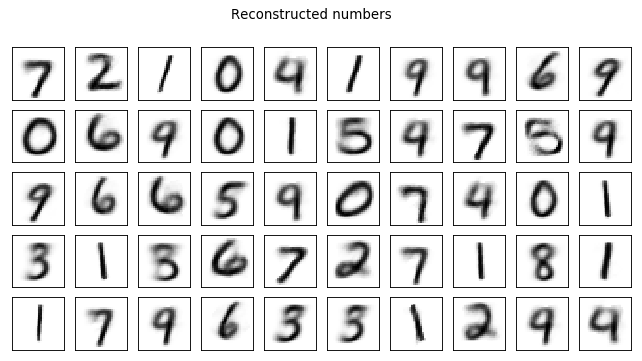

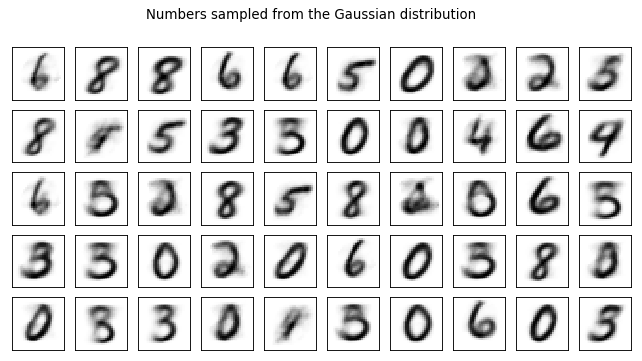

Test losses:
Reconstruction loss: 0.0007986344280652702
Discriminator loss: 0.003133914666250348

Epoch 12, losses:
Reconstruction loss: 0.14346051216125488
Discriminator loss: 0.6406782865524292

Epoch 12, losses:
Reconstruction loss: 0.1390865296125412
Discriminator loss: 0.6388962864875793



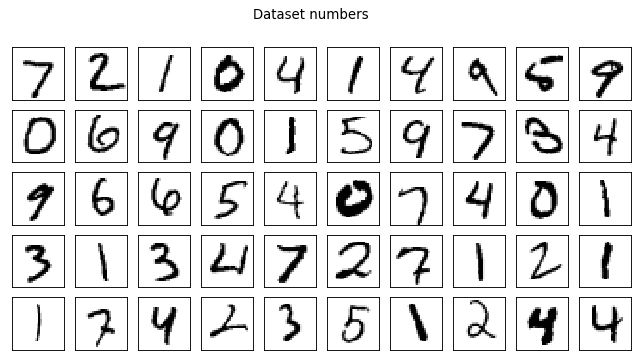

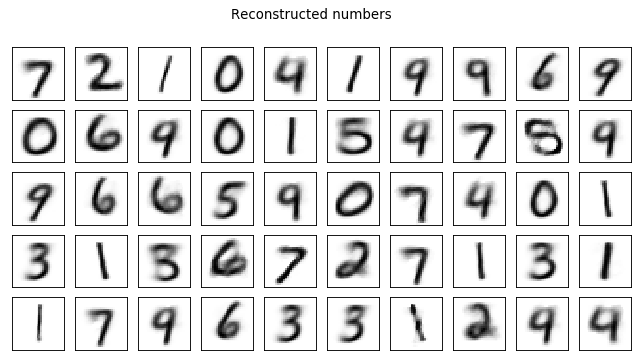

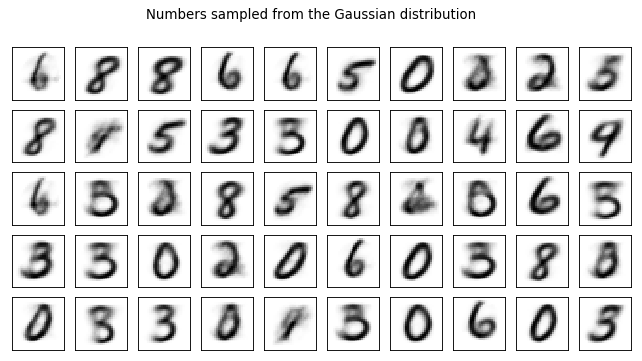

Test losses:
Reconstruction loss: 0.0006971390685066581
Discriminator loss: 0.003013256238773465

Epoch 13, losses:
Reconstruction loss: 0.146552175283432
Discriminator loss: 0.6195944547653198

Epoch 13, losses:
Reconstruction loss: 0.15191756188869476
Discriminator loss: 0.6149157881736755



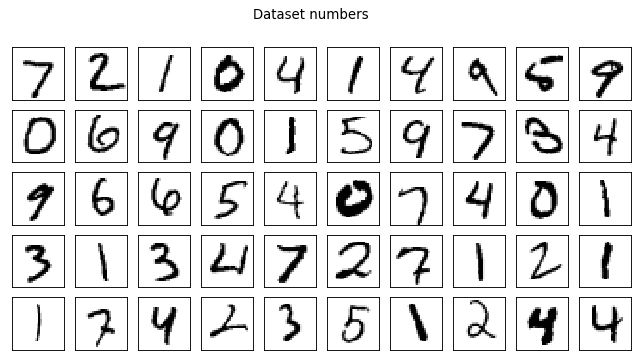

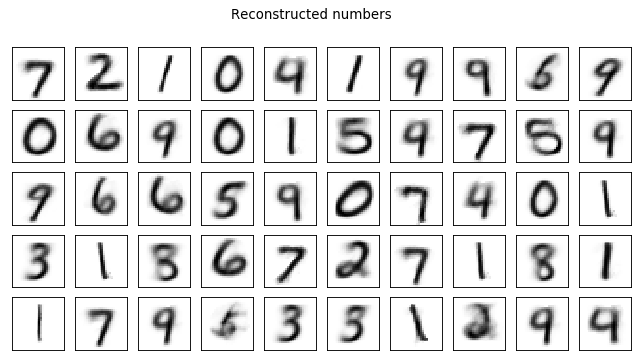

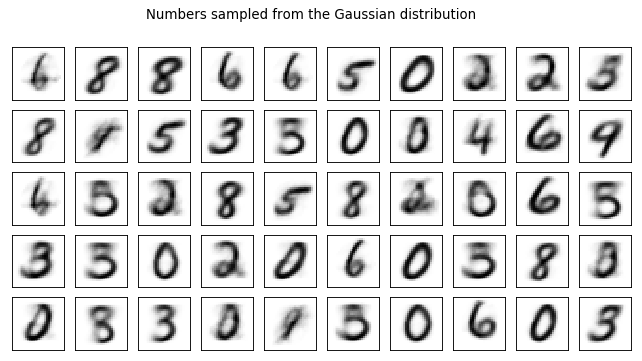

Test losses:
Reconstruction loss: 0.000787620316259563
Discriminator loss: 0.003180895233526826

Epoch 14, losses:
Reconstruction loss: 0.1432945728302002
Discriminator loss: 0.6342521905899048

Epoch 14, losses:
Reconstruction loss: 0.14852593839168549
Discriminator loss: 0.6496025919914246



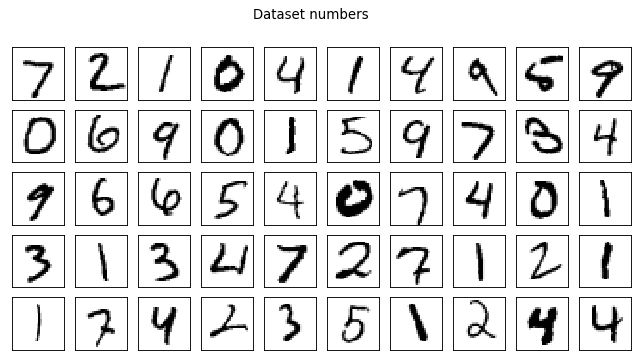

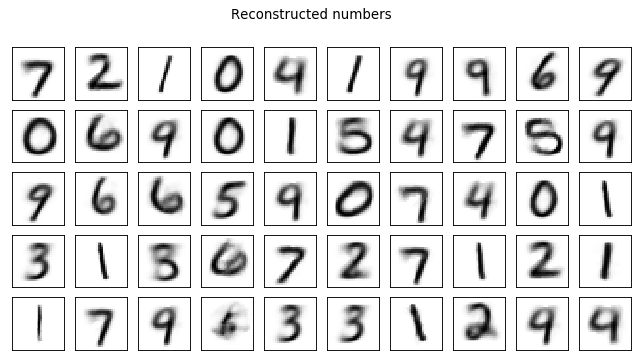

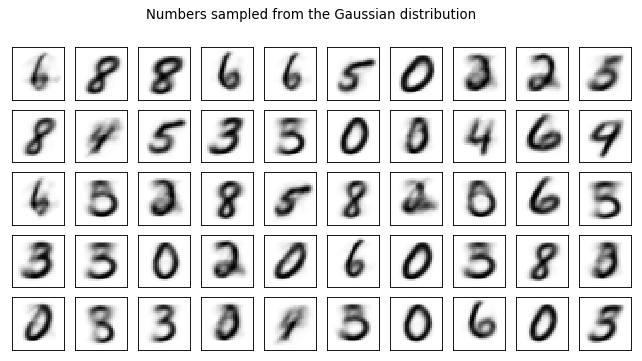

Test losses:
Reconstruction loss: 0.0007284171879291534
Discriminator loss: 0.003260973608121276

Epoch 15, losses:
Reconstruction loss: 0.1267256885766983
Discriminator loss: 0.603323757648468

Epoch 15, losses:
Reconstruction loss: 0.13927891850471497
Discriminator loss: 0.6310299634933472



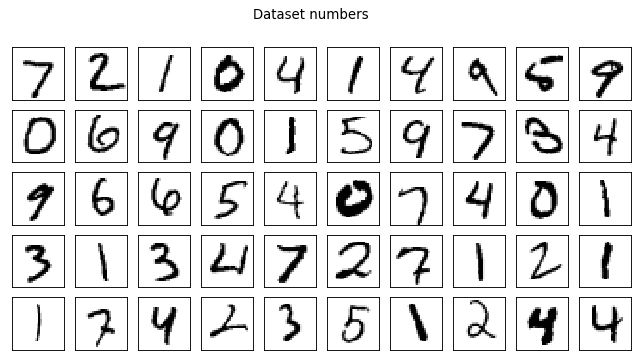

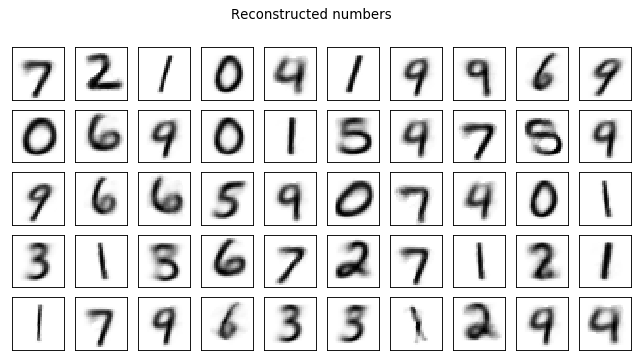

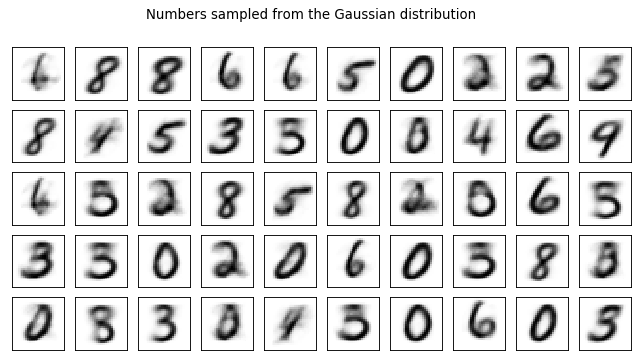

Test losses:
Reconstruction loss: 0.0007321296725422144
Discriminator loss: 0.00307853939011693

Epoch 16, losses:
Reconstruction loss: 0.147068589925766
Discriminator loss: 0.6364525556564331

Epoch 16, losses:
Reconstruction loss: 0.1616104245185852
Discriminator loss: 0.6288452744483948



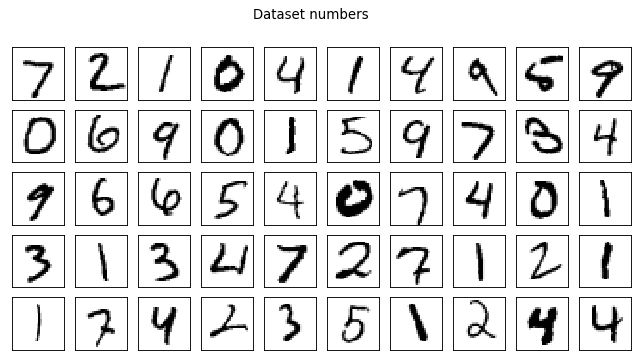

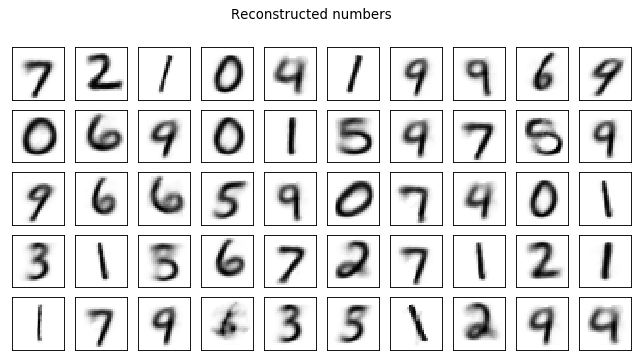

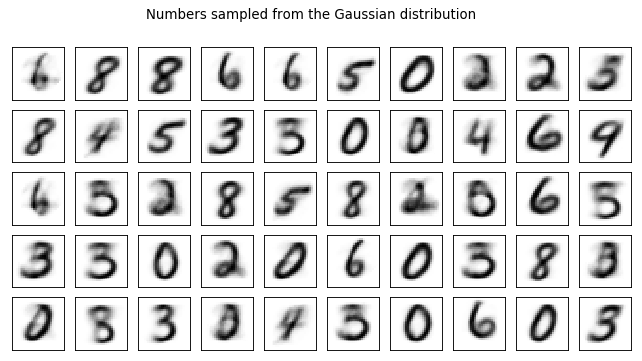

Test losses:
Reconstruction loss: 0.0008224586490541697
Discriminator loss: 0.0031120539642870426

Epoch 17, losses:
Reconstruction loss: 0.13856594264507294
Discriminator loss: 0.617307186126709

Epoch 17, losses:
Reconstruction loss: 0.1301891952753067
Discriminator loss: 0.6330640316009521



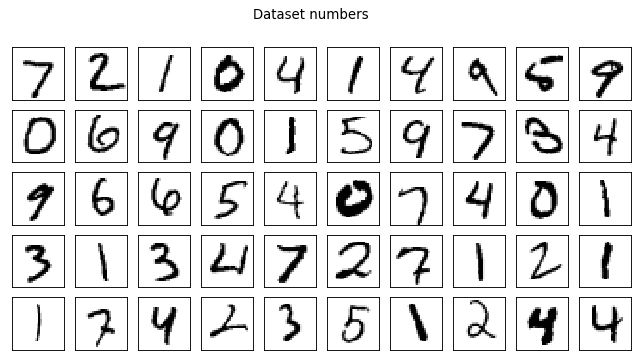

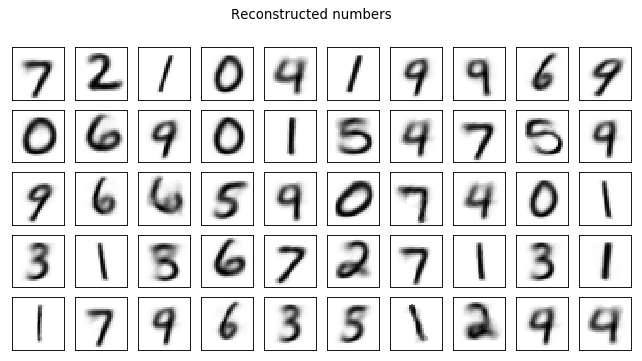

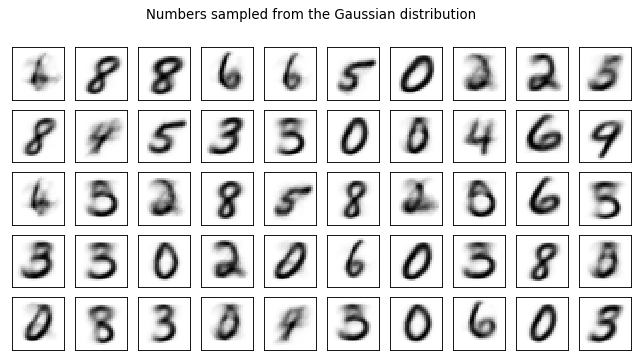

Test losses:
Reconstruction loss: 0.0006617566104978323
Discriminator loss: 0.003136709099635482

Epoch 18, losses:
Reconstruction loss: 0.11528652906417847
Discriminator loss: 0.6292879581451416

Epoch 18, losses:
Reconstruction loss: 0.14858663082122803
Discriminator loss: 0.6350178718566895



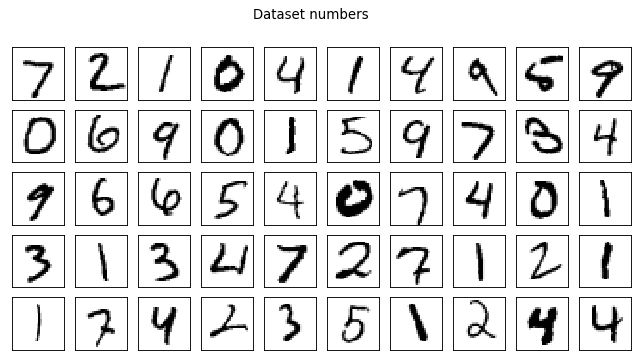

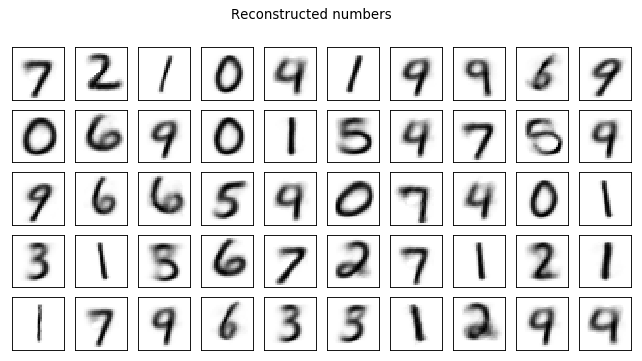

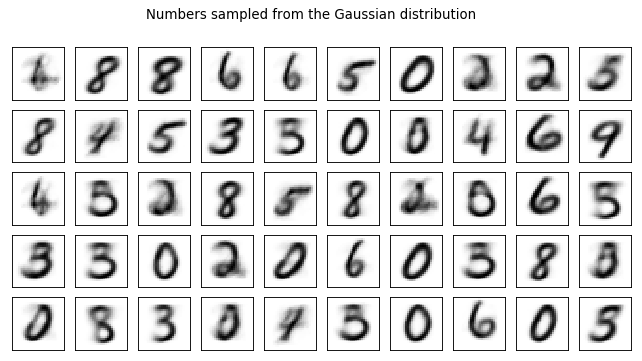

Test losses:
Reconstruction loss: 0.0006914793630130589
Discriminator loss: 0.00309853907674551

Epoch 19, losses:
Reconstruction loss: 0.13380977511405945
Discriminator loss: 0.6371899247169495

Epoch 19, losses:
Reconstruction loss: 0.15176476538181305
Discriminator loss: 0.6078691482543945



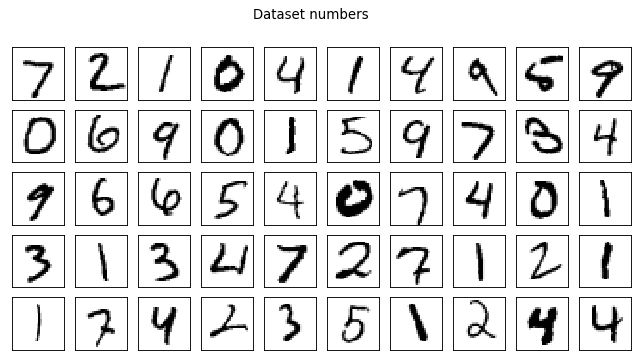

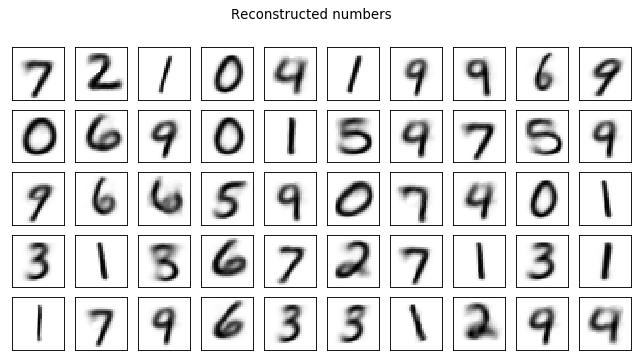

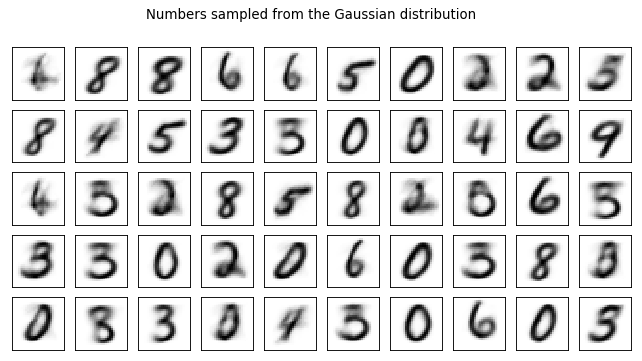

Test losses:
Reconstruction loss: 0.000673420203384012
Discriminator loss: 0.0029769621323794127

Epoch 20, losses:
Reconstruction loss: 0.14175158739089966
Discriminator loss: 0.6346418857574463

Epoch 20, losses:
Reconstruction loss: 0.14883753657341003
Discriminator loss: 0.6236717700958252



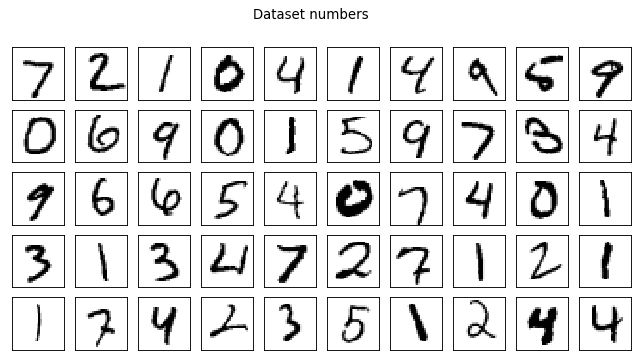

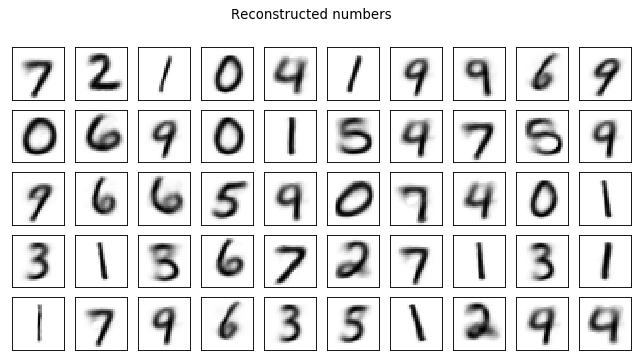

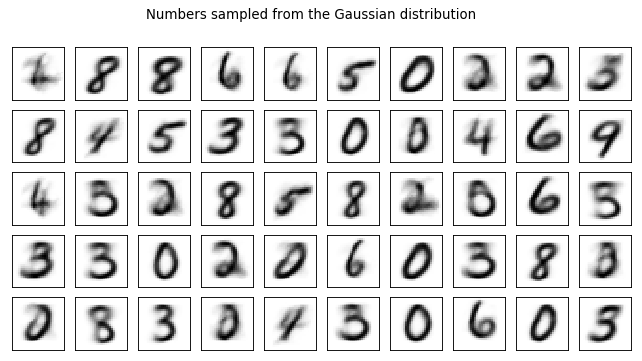

Test losses:
Reconstruction loss: 0.00082154362462461
Discriminator loss: 0.00312831555493176

Epoch 21, losses:
Reconstruction loss: 0.1314585953950882
Discriminator loss: 0.6058175563812256

Epoch 21, losses:
Reconstruction loss: 0.150971919298172
Discriminator loss: 0.6259555220603943



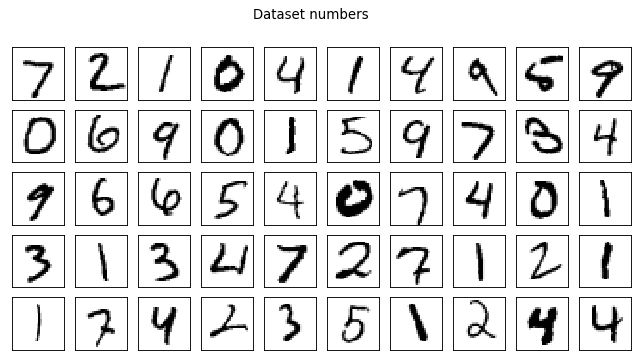

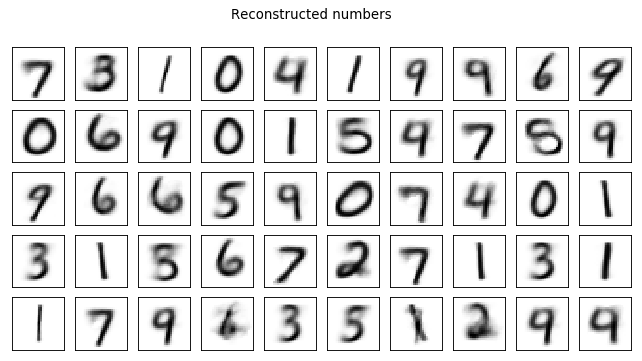

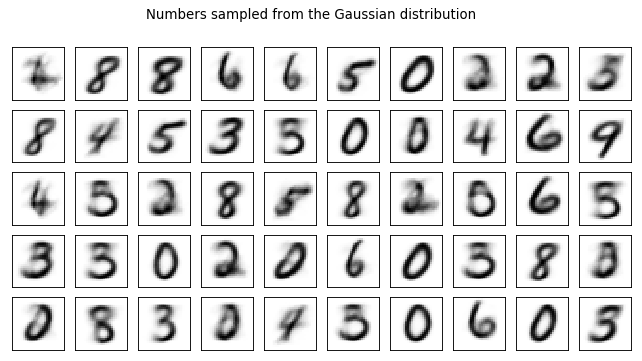

Test losses:
Reconstruction loss: 0.0006691799499094486
Discriminator loss: 0.0030889404006302357

Epoch 22, losses:
Reconstruction loss: 0.12680557370185852
Discriminator loss: 0.6042190790176392

Epoch 22, losses:
Reconstruction loss: 0.12276724725961685
Discriminator loss: 0.6142922043800354



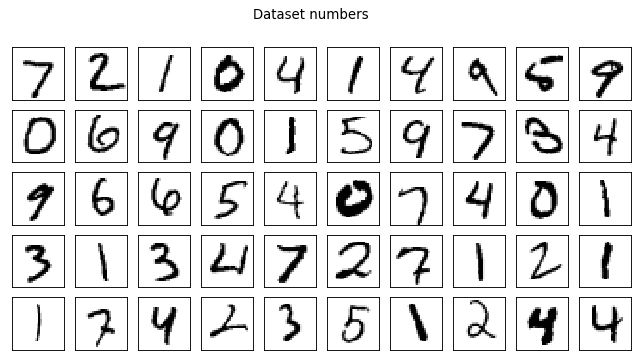

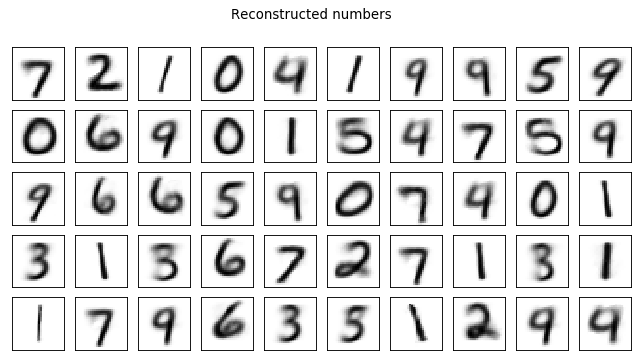

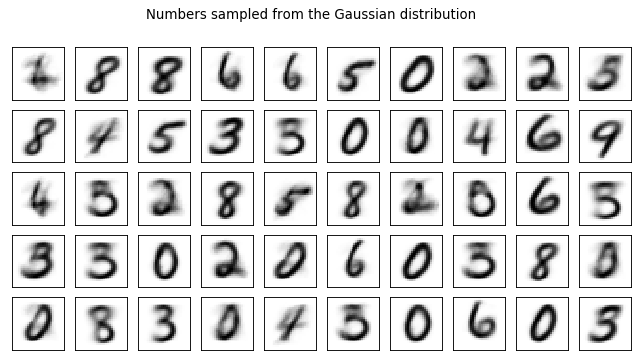

Test losses:
Reconstruction loss: 0.0006937884027138352
Discriminator loss: 0.003163347952067852

Epoch 23, losses:
Reconstruction loss: 0.1463853418827057
Discriminator loss: 0.6700745224952698

Epoch 23, losses:
Reconstruction loss: 0.12660135328769684
Discriminator loss: 0.6012651920318604



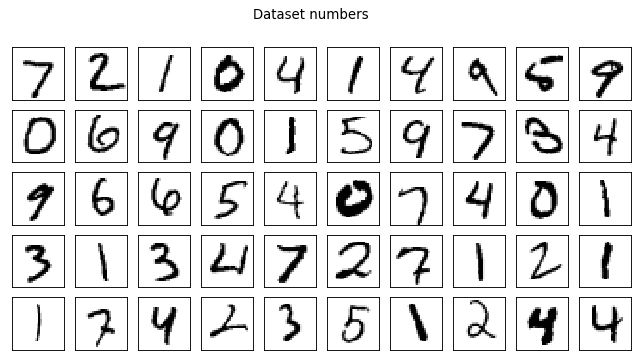

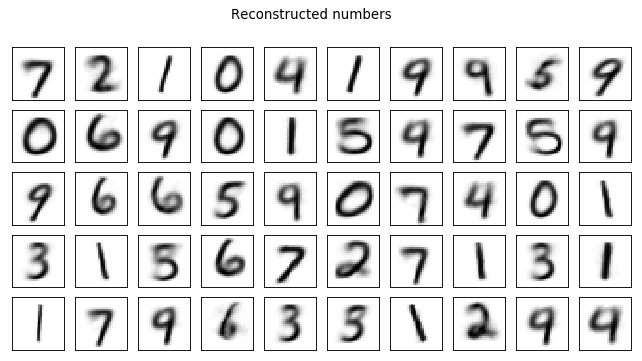

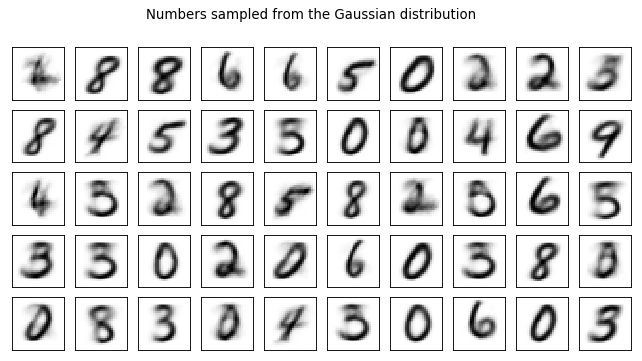

Test losses:
Reconstruction loss: 0.0007797795697115362
Discriminator loss: 0.003222472034394741

Epoch 24, losses:
Reconstruction loss: 0.12704144418239594
Discriminator loss: 0.6205737590789795

Epoch 24, losses:
Reconstruction loss: 0.13781151175498962
Discriminator loss: 0.6277387142181396



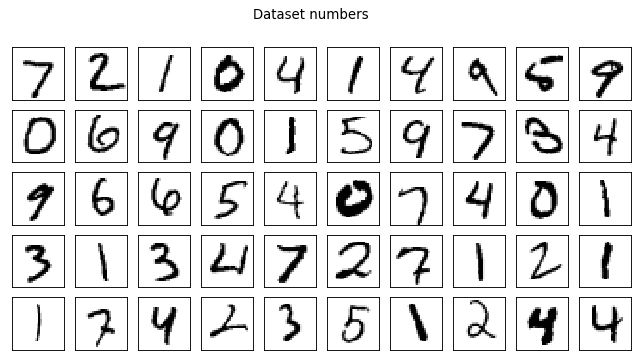

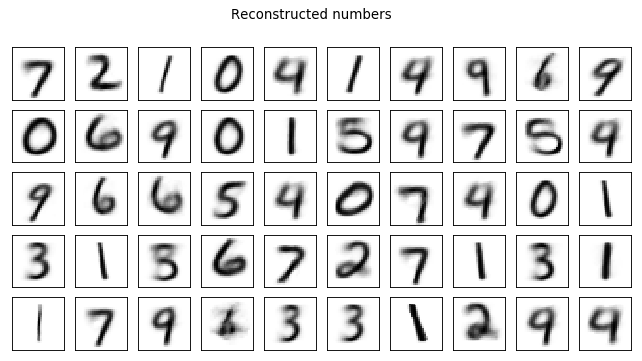

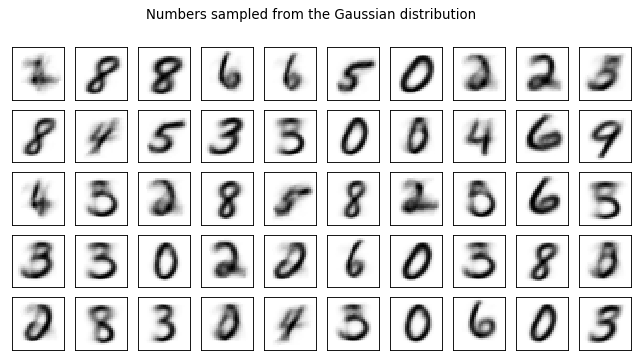

Test losses:
Reconstruction loss: 0.0007403886411339045
Discriminator loss: 0.003170272335410118

Epoch 25, losses:
Reconstruction loss: 0.14725136756896973
Discriminator loss: 0.5938968658447266

Epoch 25, losses:
Reconstruction loss: 0.12325623631477356
Discriminator loss: 0.6134794354438782



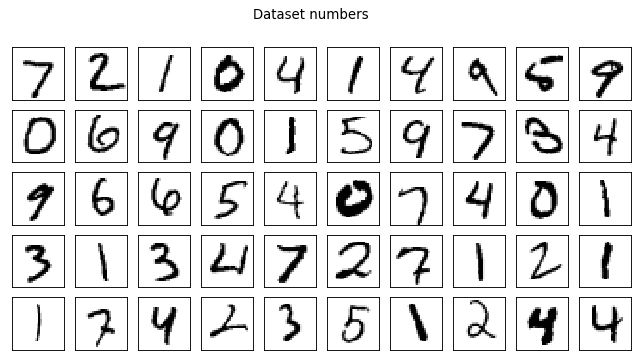

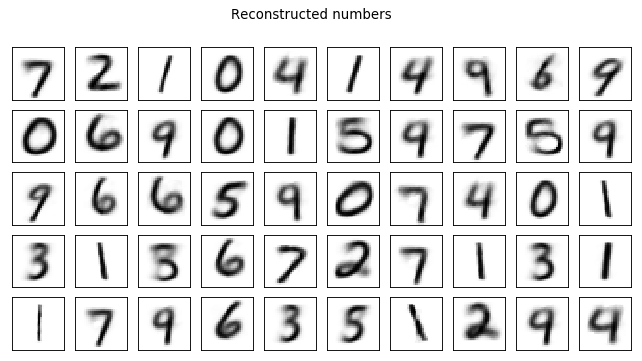

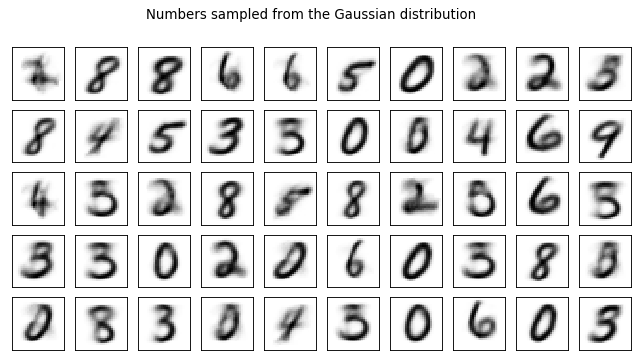

Test losses:
Reconstruction loss: 0.0006469620857387781
Discriminator loss: 0.0030001432169228792

Epoch 26, losses:
Reconstruction loss: 0.13610900938510895
Discriminator loss: 0.6288187503814697

Epoch 26, losses:
Reconstruction loss: 0.1432017683982849
Discriminator loss: 0.599882185459137



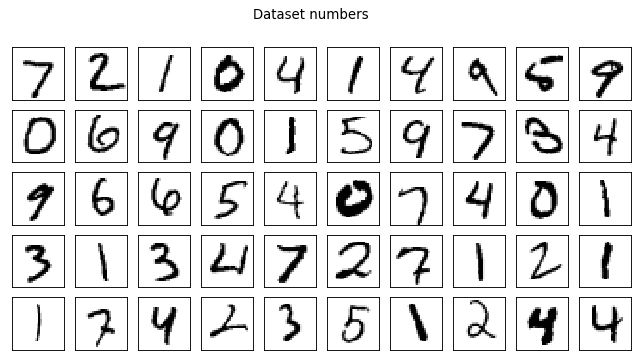

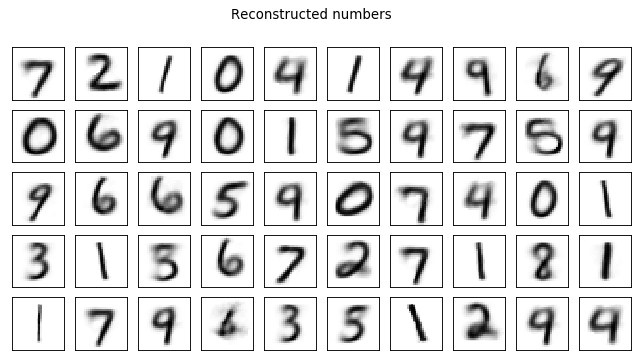

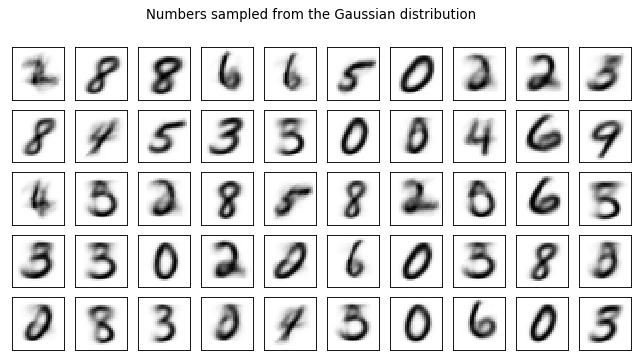

Test losses:
Reconstruction loss: 0.0006840659771114588
Discriminator loss: 0.0030988019425421953

Epoch 27, losses:
Reconstruction loss: 0.13629385828971863
Discriminator loss: 0.6340640783309937

Epoch 27, losses:
Reconstruction loss: 0.16692543029785156
Discriminator loss: 0.632365345954895



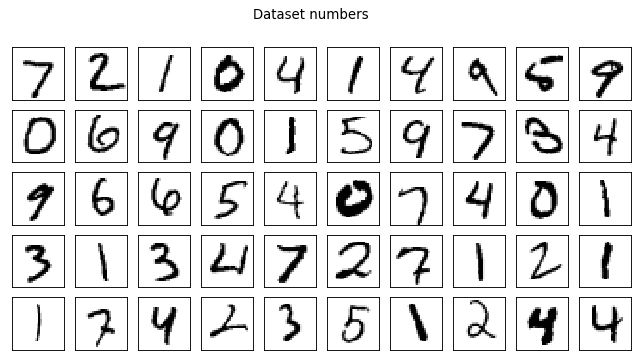

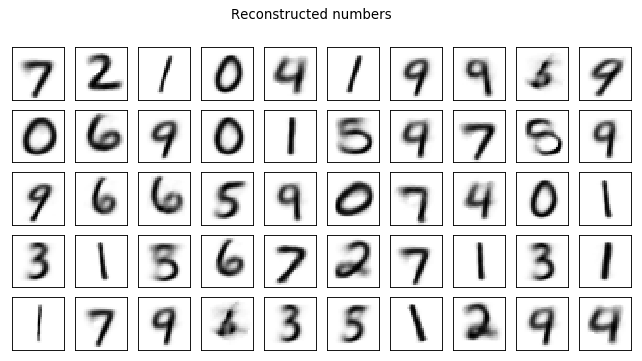

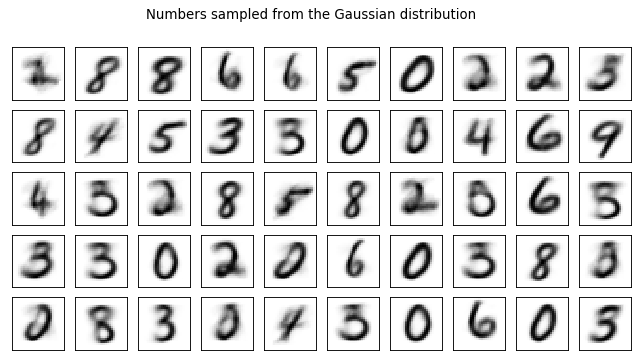

Test losses:
Reconstruction loss: 0.0006538283196277916
Discriminator loss: 0.0031743699219077826

Epoch 28, losses:
Reconstruction loss: 0.13777044415473938
Discriminator loss: 0.6037524938583374

Epoch 28, losses:
Reconstruction loss: 0.13172249495983124
Discriminator loss: 0.632988452911377



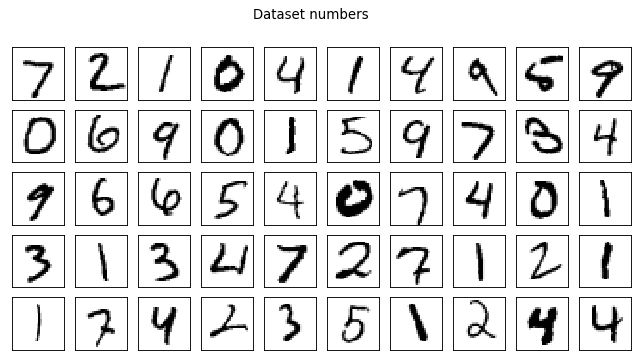

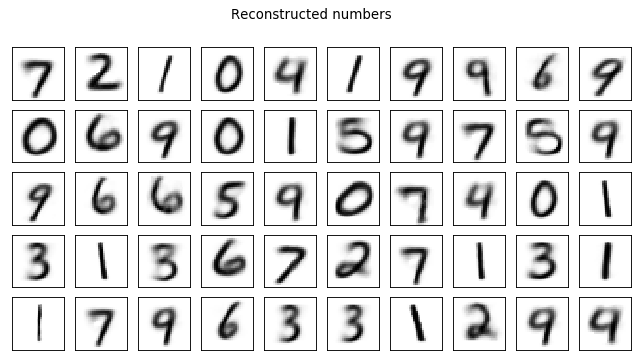

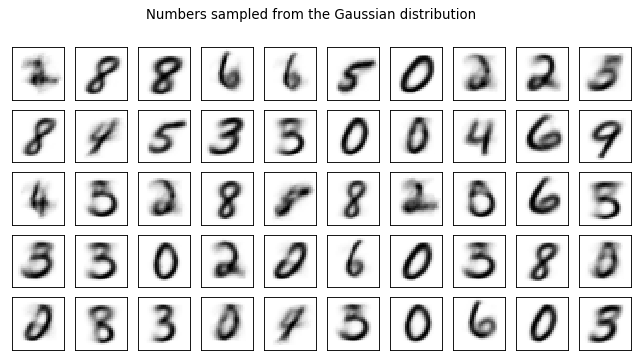

Test losses:
Reconstruction loss: 0.000683428137563169
Discriminator loss: 0.0030204923823475838

Epoch 29, losses:
Reconstruction loss: 0.14580050110816956
Discriminator loss: 0.5868557095527649

Epoch 29, losses:
Reconstruction loss: 0.124016173183918
Discriminator loss: 0.6017137169837952



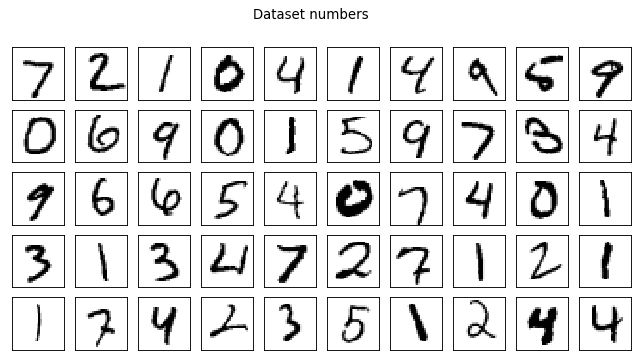

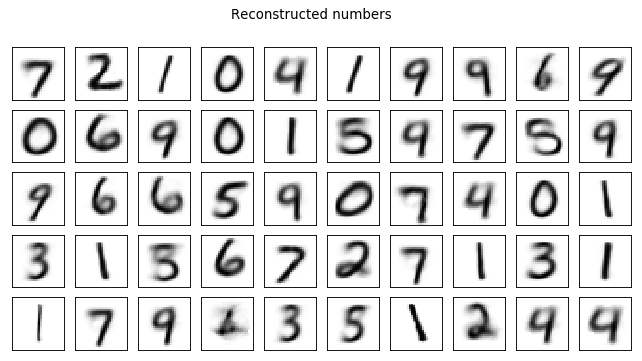

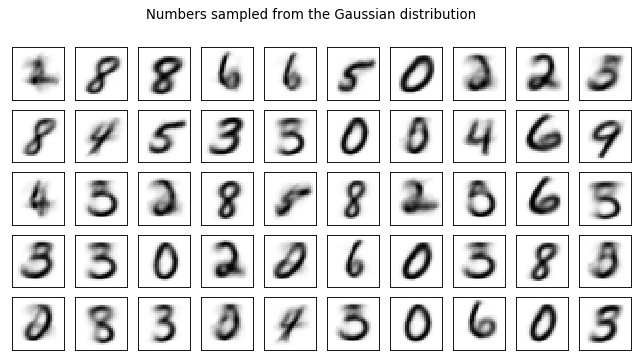

Test losses:
Reconstruction loss: 0.0006300243549048901
Discriminator loss: 0.0030485133174806833

Epoch 30, losses:
Reconstruction loss: 0.14173556864261627
Discriminator loss: 0.6083918809890747

Epoch 30, losses:
Reconstruction loss: 0.13771338760852814
Discriminator loss: 0.6267842054367065



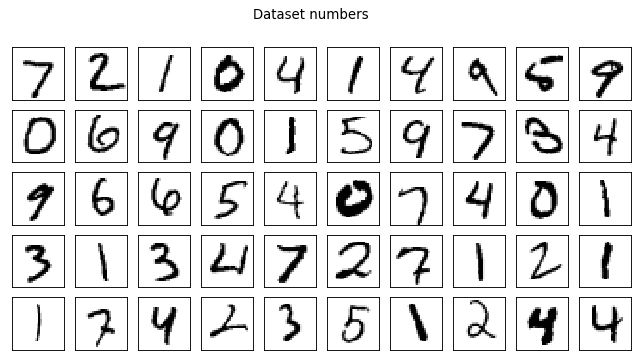

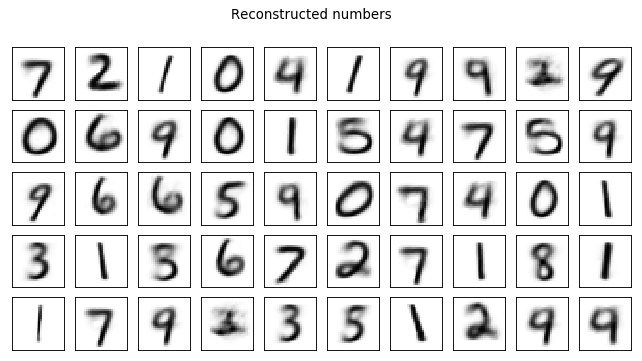

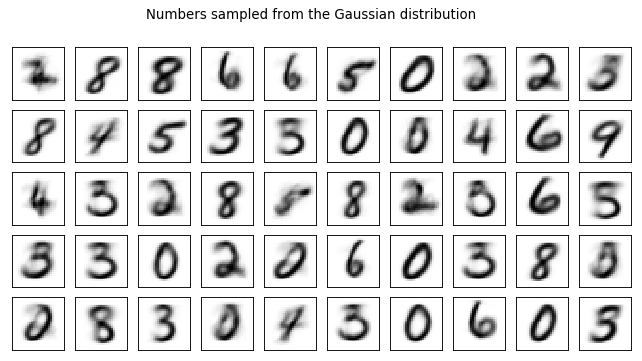

Test losses:
Reconstruction loss: 0.0007124477415345609
Discriminator loss: 0.0030747130513191223



In [10]:
with torch.cuda.device(0):
    for epoch in range(1, 31):
        enc.train()
        dec.train()
        disc.train()
        train(epoch, enc, dec, disc)
        enc.eval()
        dec.eval()
        disc.eval()
        test(enc, dec, disc, valid_loader)